# GENERATING IMAGES USING VARIATIONAL AUTOENCODER

In [13]:
import sys
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

## Loading & Analyzing the Dataset

In [4]:

# Loads the dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## Preparing Dataset

In [11]:
# Considering the datatype, values are normalized in range 0 — 1 by dividing each value by 255

X_train_full = X_train_full / 255.
X_test = X_test / 255.

In [14]:
# Separates validation set from full train set stratifically

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=10_000, random_state=42, stratify=y_train_full)

## Modeling

In [5]:

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

**Modeling Variation Encoder**

In [6]:
tf.random.set_seed(42)

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)       # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)    # γ
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

**Modeling Variational Decoder**

In [7]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)

variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

**Combining Encoder & Decoder**

In [8]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [9]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)

variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [15]:
# Compiles model
variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())

# Fits the model
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_val, X_val))

Epoch 1/25
391/391 [==============================] - 9s 15ms/step - loss: 0.0528 - val_loss: 0.0393
Epoch 2/25
391/391 [==============================] - 7s 17ms/step - loss: 0.0374 - val_loss: 0.0359
Epoch 3/25
391/391 [==============================] - 5s 14ms/step - loss: 0.0352 - val_loss: 0.0346
Epoch 4/25
391/391 [==============================] - 7s 19ms/step - loss: 0.0342 - val_loss: 0.0339
Epoch 5/25
391/391 [==============================] - 6s 14ms/step - loss: 0.0335 - val_loss: 0.0333
Epoch 6/25
391/391 [==============================] - 7s 17ms/step - loss: 0.0331 - val_loss: 0.0329
Epoch 7/25
391/391 [==============================] - 5s 13ms/step - loss: 0.0328 - val_loss: 0.0326
Epoch 8/25
391/391 [==============================] - 7s 17ms/step - loss: 0.0325 - val_loss: 0.0325
Epoch 9/25
391/391 [==============================] - 5s 13ms/step - loss: 0.0324 - val_loss: 0.0322
Epoch 10/25
391/391 [==============================] - 6s 15ms/step - loss: 0.0322 - val_lo

## Generating Images

In [16]:
# Generates a few random codings and decodes them:

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

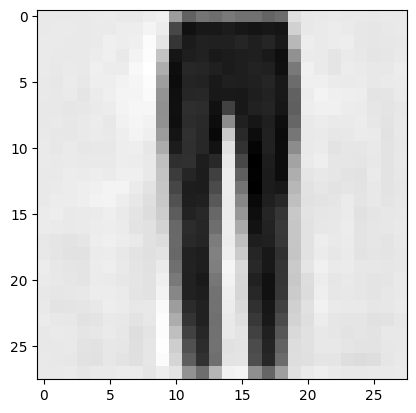

In [19]:
plt.imshow(images[0], cmap="binary")

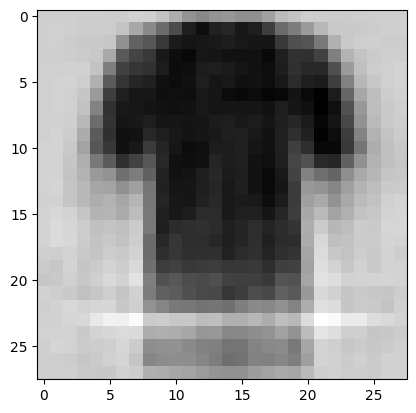

In [20]:
plt.imshow(images[1], cmap="binary")